
One way to eleminate forgetting while keeping the benefits of transfer learning is to expand the network architecture with every task. By doing this, one can increase the capacity of the network to learn new tasks while retaining its perfromance on older ones. An example approach to achieve CL via architecture expansion is [Progressive Neural Networks(PNN)](https://arxiv.org/abs/1606.04671.pdf).

**PNN**

PNN works by having a part of the network (a column) dedicated to each task. Upon adding new tasks the previous columns weights get frozen so the network perfromance on those columns is fixed. To make the new columns benefit from the old columns knowledge through transfer learning, lateral connections `a` are added. By having a seperate lateral connections, the new column can learn from previous columns without decreasing the performance on the old tasks. 

The image below shows a network of 3 tasks upon adding the third task. The dashed lines are frozen weights to fix task 1 & 2 performance and `a` connections are used to link old tasks knowledge to the new task.

<img src="https://qph.fs.quoracdn.net/main-qimg-c1e7ad14cca99e0b97475ad014e02397.webp" align="center"> </img>

This network offers one the architecture-based techniques to solve CL. That being said, the expansion per task can be limiting when the number of tasks increases. This in addition to that the network expects to have the task-id at inference time are important drawbacks of this architecture. It's still intuitive and an important benchmark so we'll discuss how to make a simple PNN.


In [ ]:
# some initial imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [ ]:
# Get MNIST data
!git clone https://github.com/ContinualAI/colab.git continualai/colab

from continualai.colab.scripts import mnist
mnist.init()

Cloning into 'continualai/colab'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 244 (delta 67), reused 88 (delta 41), pack-reused 120
Receiving objects: 100% (244/244), 10.23 MiB | 39.09 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Download complete.
Save complete.



Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
# we will construct 5 tasks of MNIST, where every task is responsible for 2 digits
x_train, t_train, x_test, t_test = mnist.load()
# tasks to use
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

task_data = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]

  task_data.append((x_train_task, t_train_task - (i * 2), 
                    x_test_task, t_test_task - (i * 2)))


First we need to build a network for each column and combine those later in the main network. A column is just like an ordinary network with the exception of the lateral connections from the previous columns. An important part is that all the previous columns need to be infered before the current column, so that it can use the output with the lateral connections.

To limit the expansion of the network we'll decrease the size on the columns of tasks that come after the first task. In the code we use a hidden layer of size `128` for task#1 and `32` for all the subsequent tasks.    

In [ ]:
class Column(nn.Module):
  def __init__(self,  col_id=0, hsize=128):
    super().__init__()
    # new layers per column
    self.l1 = nn.Linear(784, hsize)
    self.l2 = nn.Linear(hsize, 2)
    # lateral connections for old intermediate outputs
    # a set of connections per layer
    self.Us = nn.ModuleList()
    self.col_id = col_id
    for col_i in range(self.col_id):
      h = 128 if col_i == 0 else 32
      lateral = nn.Linear(h, 2)
      self.Us.append(lateral)

  def add_lateral(self, x, prev_cols, lateral_weights):
    """Compute the o/p of lateral connections.
     Returns zeros tensor for first column.
     lateral_weights ([int]): list of weights to control
     the lateral connections"""
    outputs = torch.zeros_like(x)
    for col_id, col in enumerate(prev_cols):
      input = col.outputs
      if lateral_weights:
        input = input * lateral_weights[col_id]
      layer = self.Us[col_id]
      outputs += layer(input)
    return outputs

  def freeze(self):
    "freezes all parameters of the column. To be used when adding new columns."
    for param in self.parameters():
      param.requires_grad = False

  def forward(self, x, prev_cols, lateral_weights):
    "lateral_weights ([int]): list of weights to control the lateral connections"
    # 1- Transfer Learning
    # for all previous columns, compute old transfered knowledge
    # and save it to the instance of the column
    for i, col in enumerate(prev_cols):
      # compute all layers first
      l_w = lateral_weights[:i+1]
      col(x, prev_cols[:i], l_w)

    # 2- New Knowledge
    # input/1st layer
    x = x.view(x.size(0), -1)
    x = F.relu(self.l1(x))
    # save intermediate outputs of current col
    self.outputs = x
    # last/2nd layer
    x = self.l2(x)
    # add lateral connextion o/p from all previous columns
    x += self.add_lateral(x, prev_cols=prev_cols,
                          lateral_weights=lateral_weights)

    return x

To create the whole network, we'll have a ModuleList that holds the columns. Upon adding a new task, all the columns are freezed and a new column with proper lateral connections is instantiated. For the forward pass we need to indicate which column to compute and it automatically computes all its previous columns. 

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.cols = nn.ModuleList()
  
  def add_column(self, hsize=128):
    # freeze all previous columns
    for col in self.cols:
      col.freeze()
    # create new column
    col_id = len(self.cols)
    col = Column(col_id, hsize)
    self.cols.append(col)

  def forward(self, x, id, lateral_weights=None):
    if lateral_weights is None:
      # all lateral connections are on by default
      lateral_weights = [1 for _ in range(id)]
    col = self.cols[id]
    return col(x, self.cols[:id], lateral_weights)
    

In [ ]:
# basic training and testing loops
def train(model, task_id, device, x_train, t_train,
          optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x, task_id)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, task_id, device, x_test, t_test, lateral_weights=None):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x, task_id, lateral_weights=lateral_weights)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    return test_loss, 100. * correct / len(t_test)

In the next step we'll have a function that adds a column per task. In order to investigate how much the network have used old columns' output, we'll test once with turning on all the lateral connections and another with them off.

In [ ]:
def train_PNN(epochs=10):
  "Train all 5 taks using PNN"
  accs_grid_a = []
  accs_grid_no_a = []

  # to track the increase of the number of parameters
  parameters = []
  grad_parameters = []

  net = Net()
  for task_id in range(tasks_num):
    # train on current task
    x_train, t_train, _, _ = task_data[task_id]
    # smaller column sizes from 2nd task inwards to limit expansion
    if task_id > 0:
      net.add_column(hsize=32)
    else: net.add_column()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    # increase of parameters over time
    parameters.append(sum(p.numel() for p in net.parameters()))
    grad_parameters.append(sum(p.numel() for p in net.parameters() if p.requires_grad))
    train(net, task_id, device, x_train, t_train, optimizer,
          epochs=epochs, log_training=False)

    # test on all tasks with lateral connections `a`
    
    accs_a = []
    for id in range(0, task_id + 1):
      _, _, x_test, t_test = task_data[id]
      # we'll have the lateral weights as fully-on here
      l_w = [1] * id
      _, test_acc = test(net, id, device, x_test, t_test, lateral_weights=l_w)
      accs_a.append(test_acc)
  
    if task_id < (tasks_num - 1):
      accs_a.extend([np.nan] * (4 - task_id))
    accs_grid_a.append(accs_a)


    # test on all tasks without lateral connections `a`
    accs_no_a = []
    for id in range(0, task_id + 1):
      _, _, x_test, t_test = task_data[id]
      # we'll have the lateral weights as fully-off here
      l_w = [0] * id
      _, test_acc = test(net, id, device, x_test, t_test, lateral_weights=l_w)
      accs_no_a.append(test_acc)
  
    if task_id < (tasks_num - 1):
      accs_no_a.extend([np.nan] * (4 - task_id))
    accs_grid_no_a.append(accs_no_a)

  # return accuracies with and without lateral connections 
  return accs_grid_a, accs_grid_no_a, parameters, grad_parameters

In [ ]:
accs_a, accs_no_a, parameters, grad_parameters= train_PNN(epochs=15)

We can see from the below figure that the network uses some of the knowledge learnt from previous tasks to learn new tasks. As task number increases, its dependance on lateral connections increases (due to having more more connections as the task# progresses.) MNIST problem with multi-head setting is relatively simple though and with more complex tasks we can see more prononced releance on transfer learning from previous columns and can have a proxy for task similarity. A deeper analysis can be found in [the original paper](https://arxiv.org/pdf/1606.04671.pdf)

Text(0.5, 0, 'Task Number')

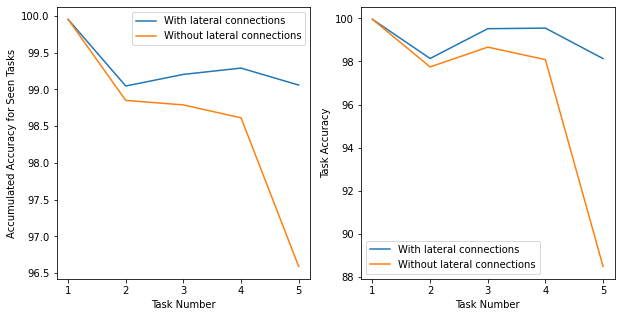

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(range(1, 6), np.nanmean(accs_a, axis=1))
ax[0].plot(range(1, 6), np.nanmean(accs_no_a, axis=1))
ax[0].legend(['With lateral connections', 'Without lateral connections'])
ax[0].set_ylabel('Accumulated Accuracy for Seen Tasks')
ax[0].set_xlabel('Task Number')

ax[1].plot(range(1, 6), accs_a[-1])
ax[1].plot(range(1, 6), accs_no_a[-1])
ax[1].legend(['With lateral connections', 'Without lateral connections'])
ax[1].set_ylabel('Task Accuracy')
ax[1].set_xlabel('Task Number')

Since we add new column for every task, the number of parameters expands. The number of learnable parameters expands in more modest rate though as we are freezing old columns. In the figure below we can see the rate at which the parameters expands. Note that since we use smaller column size starting from task 2 (32 neurons vs. 128) the learnable parameters decrease at first then increases very slowly afterwards.

In [ ]:
# Number of learnable paramters decreases after task#1, increase by just 66 after task#2
print(grad_parameters)

[100738, 25444, 25510, 25576, 25642]


Text(0.5, 0, 'Task Number')

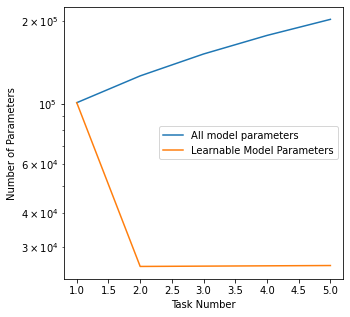

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(range(1, 6), parameters)
ax.plot(range(1, 6), grad_parameters)
ax.set_yscale('log')
ax.legend(['All model parameters', 'Learnable Model Parameters'])
ax.set_ylabel('Number of Parameters')
ax.set_xlabel('Task Number')

In [1]:
!git status


fatal: not a git repository (or any of the parent directories): .git
